In [1]:
import pandas as pd
import pickle
import numpy  as np
from time import time
#train_test_split
from sklearn.model_selection import train_test_split
#Feature scaling
from sklearn import preprocessing
from collections import Counter
import math
import tracemalloc

In [2]:
import pickle
#数理统计方法，按5%区间进行数理统计
def statistics(dataset, feature_index):
    intervals = {'{0}-{1}'.format(5 * x, 5 * (x+1) ): 0 for x in range(20)}
    for _ in dataset[:,feature_index]:
        for interval in intervals:
            start, end = tuple(interval.split('-'))
            if int(start) <= _*100 <= int(end):
                intervals[interval] += 1
    return intervals

def save_obj(obj, name ):
    with open('../DistributionDictionary/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        

In [3]:
labelList = ["BENIGN", "DoS", "PortScan", "DDoS", "SSH-Patator", "FTP-Patator", "Web Attack", "Bot"]
distribution_feature = [    #产生的新特征
    'Benign_Score', 'DoS_Score',
    'PortScan_Score', 'DDoS_Score', 'SSH-Patator_Score', 
    'FTP-Patator_Score', 'Web Attack_Score', 'Bot_Score'
]
def load_obj(name):
    with open('../DistributionDictionary/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

distributions = {}
distributions['Benign'] = load_obj("Benign_Distribution_set")
distributions['DoS'] = load_obj("DoS_Distribution_set")
distributions['PortScan'] = load_obj("PortScan_Distribution_set")
distributions['DDoS'] = load_obj("DDoS_Distribution_set")
distributions['SSH-Patator'] = load_obj("SSH_Distribution_set")
distributions['FTP-Patator'] = load_obj("FTP_Distribution_set")
distributions['Web Attack'] = load_obj("Web_Distribution_set")
distributions['Bot'] = load_obj("Bot_Distribution_set")

feature_numbers = 10
attack_types = 7  #总已知攻击种类

#定义difference weight,取值0~1
def calculate_dw(distribution_1, distribution_2, feature_index):
    count1 = calculate_count(distribution_1, feature_index)
    count2 = calculate_count(distribution_2, feature_index)
    h = 20
    dw = 0
    for i in range(h):
        start = i*5
        end = start + 5
        T1 = distribution_1[str(feature_index)][str(start) + '-' + str(end)]/count1
        T2 = distribution_2[str(feature_index)][str(start) + '-' + str(end)]/count2
        dw += abs(T1 - T2)
    return dw/2
#用于计算分布字典里的实例数
def calculate_count(distribution, feature_index):
    h = 20
    count = 0
    for i in range(h):
        start = i*5
        end = start + 5
        count += distribution[str(feature_index)][str(start) + '-' + str(end)]
    return count
#定义hdw，hybird difference weight  第二个参数为：hdw应用的对应得分公式的对应的哪种字典
def calculate_hdw(feature_index, label):
    base = 0
    for key in distributions:
        if(key == label):
            continue
        dw = calculate_dw(distributions[label], distributions[key], feature_index)
        if(dw > base):
            base = dw
    return base

#计算例子在某种标签上的得分，需要提供对应标签, 这个标签的的分布统计字典
def get_score(example, distributeObj, label):    
    score = 0
    count = calculate_count(distributeObj, 0)  #取哪个特征都一样
    minBase = 1
    baseArr = []
    for i in range(feature_numbers):

        start = int(example[i]/0.05//1)*5   #取200个分组里的分组起始位置
        if(start == 100):     #特殊处理当该属性为1.0时溢出的情况
            start = 95      
        end = start + 5
        dataRange = '{0}-{1}'.format(start, end )
        base = distributeObj[str(i)][dataRange]/count
        if(base != 0 and base < minBase):
            minBase = base
        baseArr.append(base)
        
    for i in range(feature_numbers):
        if(baseArr[i] != 0):
            score += math.log(baseArr[i]) * calculate_hdw(i, label)  / feature_numbers
        else:
            score += math.log(minBase) * calculate_hdw(i, label)  / feature_numbers
            
    return score


def get_score_threshold(dataset_x, dataset_y):
    #5个分数数组，表示在这个label字典下label实例的得分情况
    Scores = {
        "Benign" : [],
        "DoS" : [],
        "PortScan" : [],
        "DDoS" : [],
        "SSH-Patator" : [],        
        "FTP-Patator" : [],
        "Web Attack" : [],
        "Bot" : []
    }
    for i,item in enumerate(dataset_x):
        if(dataset_y.values[i].astype('int') == 0):
            
            Scores["Benign"].append(get_score(item, distributions['Benign'], 'Benign'))
            
        elif(dataset_y.values[i].astype('int') == 1):
            
            Scores["DoS"].append(get_score(item, distributions['DoS'], 'DoS'))
            
        elif(dataset_y.values[i].astype('int') == 2):
            
            Scores["PortScan"].append(get_score(item, distributions['PortScan'], 'PortScan'))
            
        elif(dataset_y.values[i].astype('int') == 3):
            
            Scores["DDoS"].append(get_score(item, distributions['DDoS'], 'DDoS'))
            
        elif(dataset_y.values[i].astype('int') == 4):
            
            Scores["SSH-Patator"].append(get_score(item, distributions['SSH-Patator'], 'SSH-Patator'))
        
        elif(dataset_y.values[i].astype('int') == 5):
            
            Scores["FTP-Patator"].append(get_score(item, distributions['FTP-Patator'], 'FTP-Patator'))
            
        elif(dataset_y.values[i].astype('int') == 6):
            
            Scores["Web Attack"].append(get_score(item, distributions['Web Attack'], 'Web Attack'))
            
        elif(dataset_y.values[i].astype('int') == 7):
            
            Scores["Bot"].append(get_score(item, distributions['Bot'], 'Bot'))
            
    thresholds = []
    
    for item in Scores.values():
        item.sort()
        thresholds.append(item[len(item)//10])    #取”将样例分成1：9“的threshold
    return thresholds

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + np.exp(-x))

def fill_score(i, item, Score_revert, label, label_num):
    #计算得分
    score = get_score(item, distributions[label], label)
    #score-normalization
    score_norm = sigmoid(score - thresholds[label_num])
    #放入要拼接的表
    Score_revert.loc[i, (label + '_Score')] = score_norm
    return

def create_distribution_score(dataset_x, thresholds):
    #创建空表
    Score_revert = pd.DataFrame(
        data=np.zeros(
            shape=(
                dataset_x.shape[0],
                len(distribution_feature)
            )
        ),columns = distribution_feature
    )
    #填充空表
    for i,item in enumerate(dataset_x):
        fill_score(i, item, Score_revert, 'Benign', 0)
        fill_score(i, item, Score_revert, 'DoS', 1)
        fill_score(i, item, Score_revert, 'PortScan', 2)
        fill_score(i, item, Score_revert, 'DDoS', 3)
        fill_score(i, item, Score_revert, 'SSH-Patator', 4)
        fill_score(i, item, Score_revert, 'FTP-Patator', 5)
        fill_score(i, item, Score_revert, 'Web Attack', 6)
        fill_score(i, item, Score_revert, 'Bot', 7)
            
    dataset_x = np.hstack((dataset_x,Score_revert.values))
    return dataset_x


In [4]:
def read_csv(dataroot):
    df=pd.read_csv(dataroot,header=0,low_memory=False)   
    pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
    df['Flow Bytes/s']=df['Flow Bytes/s'].astype('float64')
    df[' Flow Packets/s']=df[' Flow Packets/s'].astype('float64')
    df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(),inplace=True)
    df[' Flow Packets/s'].fillna(df[' Flow Packets/s'].mean(),inplace=True)
    return df

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset[' Label'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 

#独热编码。选取distination port统计大于等于10以上的port作为新增维度
def create_columns_for_destination_port(train_dataset):
    countDictionary = Counter(train_dataset[' Destination Port'])
    columns = []
    columns.append('DestinationPort_Others')
    for key in countDictionary:
        if(countDictionary[key] >= 10):
            columns.append('DestinationPort_' + str(key))
    return columns

def one_hot_process_for_destination_port(dataset, columns):
    #重置索引
    dataset = dataset.reset_index(drop=True)
    #创建空表
    DestinationPort_revert = pd.DataFrame(data=np.zeros(shape=(dataset.shape[0],len(columns))), columns = columns)
    #填充空表
    for i,value in enumerate(dataset[' Destination Port'].values):
        name = "DestinationPort_" + str(value)
        if name in columns:
            DestinationPort_revert.loc[i, name] = 1
        else:
            DestinationPort_revert.loc[i, "DestinationPort_Others"] = 1
    #与原表连接
    dataset = pd.concat([dataset, DestinationPort_revert], axis=1)
    #删除原表的destination port列
    dataset = dataset.drop([' Destination Port'], axis=1)
    return dataset  



def labels_separate(dataset):
    y_ = dataset[' Label']
    temp = dataset
    temp.drop([' Label'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    if label == 'BENIGN':
        return 0
    if label == 'DoS':
        return 1
    if label == 'PortScan':
        return 2
    if label == 'DDoS':
        return 3
    if label == 'SSH-Patator':
        return 4
    if label == 'FTP-Patator':
        return 5
    if label == 'Web Attack':
        return 6
    if label == 'Bot':
        return 7
    return -1   #-1表示出错

def filter_labels(dataset):
    dataset[' Label'] = dataset[' Label'].apply(labels_map)
    return dataset
#特征选取
def feature_selection(dataset):
    return dataset[[
        'Total Length of Fwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Mean', 
        ' Bwd Packet Length Mean', ' Packet Length Mean', ' Packet Length Std', ' Average Packet Size', 
        ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', 'DestinationPort_80', 
        'DestinationPort_21', 'DestinationPort_22',
        ' Label'
    ]]

In [5]:
#DDoS
df_1 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_1 = df_1.drop(df_1[df_1[' Label'] == 'BENIGN'].index)
df_1 = df_1.sample(n=5000,random_state=1, replace=False)
df_1_train, df_1_test = split_valid_from_train(df_1, 0.2)
#PortScan
df_2 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_2 = df_2.drop(df_2[df_2[' Label'] == 'BENIGN'].index)
df_2 = df_2.sample(n=5000,random_state=1, replace=False)
df_2_train, df_2_test = split_valid_from_train(df_2, 0.2)
#Bot
df_3 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_3 = df_3.drop(df_3[df_3[' Label'] == 'BENIGN'].index)
df_3 = df_3.sample(n=5000,random_state=1, replace=True)
df_3_train, df_3_test = split_valid_from_train(df_3, 0.2)
#Benign
df_4 = read_csv("../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
df_4 = df_4.sample(n=50000,random_state=1, replace=False)
df_4_train, df_4_test = split_valid_from_train(df_4, 0.2)
#Web attack
df_6 = read_csv("../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_6 = df_6.drop(df_6[df_6[' Label'] == 'BENIGN'].index)
df_6 = df_6.sample(n=5000,random_state=1, replace=True)
df_6[' Label'] = df_6[' Label'].apply(lambda x: 'Web Attack')
df_6_train, df_6_test = split_valid_from_train(df_6, 0.2)
#FTP-Patator and SSH-Patator
df_7 = read_csv("../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
df_7 = df_7.drop(df_7[df_7[' Label'] == 'BENIGN'].index)
df_7_1 = df_7.drop(df_7[df_7[' Label'] == 'FTP-Patator'].index)
df_7_2 = df_7.drop(df_7[df_7[' Label'] == 'SSH-Patator'].index)
df_7_1 = df_7_1.sample(n=5000,random_state=1, replace=False)
df_7_2 = df_7_2.sample(n=5000,random_state=1, replace=False)
df_7_1_train, df_7_1_test = split_valid_from_train(df_7_1, 0.2)
df_7_2_train, df_7_2_test = split_valid_from_train(df_7_2, 0.2)
#DoS
df_8 = read_csv("../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
df_8 = df_8.drop(df_8[df_8[' Label'] == 'BENIGN'].index)
df_8 = df_8.sample(n=5000,random_state=1, replace=False)
df_8[' Label'] = df_8[' Label'].apply(lambda x: 'DoS')
df_8_train, df_8_test = split_valid_from_train(df_8, 0.2)

#整合
df_train = df_1_train.append([df_2_train, df_3_train, df_4_train, df_6_train, df_7_1_train,df_7_2_train,df_8_train])
df_test = df_1_test.append([df_2_test, df_3_test, df_4_test, df_6_test, df_7_1_test,df_7_2_test,df_8_test])

In [6]:
print(df_train.shape)
print(df_train.loc[:,' Label'].value_counts())
print(df_test.shape)
print(df_test.loc[:,' Label'].value_counts())

(68000, 79)
BENIGN         40000
PortScan        4000
SSH-Patator     4000
FTP-Patator     4000
DoS             4000
Web Attack      4000
Bot             4000
DDoS            4000
Name:  Label, dtype: int64
(17000, 79)
BENIGN         10000
DDoS            1000
PortScan        1000
SSH-Patator     1000
FTP-Patator     1000
DoS             1000
Web Attack      1000
Bot             1000
Name:  Label, dtype: int64


In [7]:
print(df_train.size)
print(df_test.memory_usage().sum())
print(df_test.shape)

5372000
10880000
(17000, 79)


In [8]:
#整合后再乱序一下
df_train = shuffle(df_train)
#标签的字符转化成数字
df_train = filter_labels(df_train)
#对destination port进行独热编码
columns = create_columns_for_destination_port(df_train)
df_train = one_hot_process_for_destination_port(df_train, columns)
#特征选择
df_train = feature_selection(df_train)
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
#Normalization
scaler = preprocessing.MinMaxScaler()
df_train_X = scaler.fit_transform(df_train_X)

In [9]:
df_test = filter_labels(df_test)
df_test = one_hot_process_for_destination_port(df_test, columns)
df_test = feature_selection(df_test)
df_test_X, df_test_y = labels_separate(df_test)
df_test_X = scaler.fit_transform(df_test_X)

In [10]:
thresholds = get_score_threshold(df_train_X, df_train_y)

In [11]:
print(thresholds)

[-1.5359972730466047, -2.39628491304749, -0.06578879416977884, -5.3861775465640385, -1.381310173920737, -4.914427872661199, -0.4721147549358896, -1.349312098006745]


In [12]:
df_train_X = create_distribution_score(df_train_X, thresholds)

In [13]:
df_test_X = create_distribution_score(df_test_X, thresholds)

In [14]:
print(df_train_X.shape)

(68000, 21)


In [45]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
#超参数设置
learning_rate = 0.001
epochs = 30
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数

In [105]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./Test7_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(128, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(32, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(8,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 21)                462       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 21)                84        
_________________________________________________________________
dense_60 (Dense)             (None, 128)               2816      
_________________________________________________________________
batch_normalization_v1_45 (B (None, 128)               512       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_v1_46 (B (None, 64)                256       
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
__________

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 00001: val_loss improved from inf to 0.96182, saving model to ./Test7_model.h5
68000/68000 [==============================] - 16s 230us/sample - loss: 0.5213 - acc: 0.8501 - val_loss: 0.9618 - val_acc: 0.6776
Epoch 2/30
67584/68000 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.9053
Epoch 00002: val_loss improved from 0.96182 to 0.52245, saving model to ./Test7_model.h5
68000/68000 [==============================] - 7s 100us/sample - loss: 0.2721 - acc: 0.9053 - val_loss: 0.5225 - val_acc: 0.7977
Epoch 3/30
67840/68000 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9147
Epoch 00003: val_loss did not improve from 0.52245
68000/68000 [==============================] - 7s 106us/sample - loss: 0.2304 - acc: 0.9147 - val_loss: 0.6376 - val_acc: 0.8598
Epoch 4/30
67584/68000 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9175
Epoch 00004: val_loss improved from 0.52245 to 0.33414, saving model to ./Test7_model.h5
68000/68000 

Epoch 25/30
67840/68000 [============================>.] - ETA: 0s - loss: 0.1244 - acc: 0.9527
Epoch 00025: val_loss did not improve from 0.25392
68000/68000 [==============================] - 6s 91us/sample - loss: 0.1243 - acc: 0.9527 - val_loss: 0.6190 - val_acc: 0.8999
Epoch 26/30
67584/68000 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9555
Epoch 00026: val_loss did not improve from 0.25392
68000/68000 [==============================] - 8s 111us/sample - loss: 0.1165 - acc: 0.9556 - val_loss: 0.5603 - val_acc: 0.8641
Epoch 27/30
67328/68000 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9593
Epoch 00027: val_loss did not improve from 0.25392
68000/68000 [==============================] - 5s 80us/sample - loss: 0.1121 - acc: 0.9593 - val_loss: 0.4407 - val_acc: 0.9038
Epoch 28/30
67328/68000 [============================>.] - ETA: 0s - loss: 0.1095 - acc: 0.9599
Epoch 00028: val_loss did not improve from 0.25392
68000/68000 [==============

In [106]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

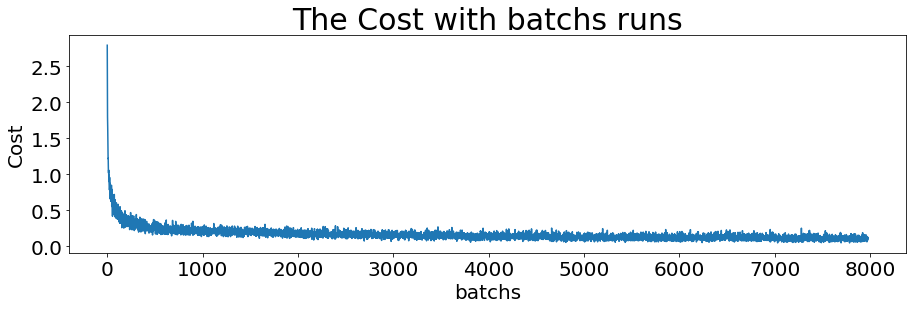

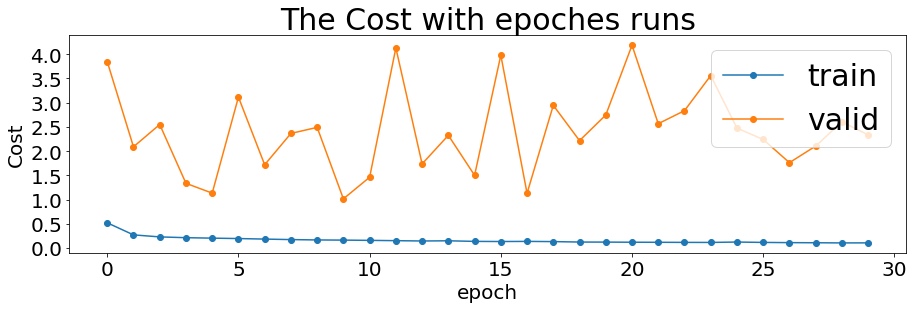

In [107]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [108]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./Test7_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

17000/17000 [==============================] - 3s 166us/sample - loss: 0.2539 - acc: 0.8673
Test accuracy: 0.86729413


In [109]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

              precision    recall  f1-score   support

      BENIGN       0.85      0.94      0.90     10000
         DoS       0.98      0.64      0.78      1000
    PortScan       0.79      0.48      0.60      1000
        DDoS       0.93      0.60      0.73      1000
 SSH-Patator       0.97      1.00      0.98      1000
 FTP-Patator       0.99      1.00      0.99      1000
  Web Attack       0.94      0.91      0.92      1000
         Bot       0.67      0.66      0.67      1000

   micro avg       0.87      0.87      0.87     17000
   macro avg       0.89      0.78      0.82     17000
weighted avg       0.87      0.87      0.86     17000



In [21]:
def save_classifier(obj, name ):
    with open('../Test11/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


# 运行程序
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
dt_clf = clf.fit(df_train_X, df_train_y)
save_classifier(dt_clf, "DT")

In [23]:
tracemalloc.start()
predictions = dt_clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))
print(tracemalloc.get_tracemalloc_memory())

[0 0 0 ... 1 1 1]
0.8950588235294118
15388


In [34]:
score = 0
for i in range(5):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
    clf.fit(df_train_X, df_train_y)
    y_pred = clf.predict(df_test_X)
    result = clf.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        

0.901
              precision    recall  f1-score   support

      BENIGN       0.86      0.99      0.92     10000
         DoS       0.99      0.99      0.99      1000
    PortScan       1.00      0.49      0.65      1000
        DDoS       0.98      0.17      0.30      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       0.99      1.00      0.99      1000
  Web Attack       0.97      0.99      0.98      1000
         Bot       0.99      0.73      0.84      1000

   micro avg       0.90      0.90      0.90     17000
   macro avg       0.97      0.80      0.84     17000
weighted avg       0.91      0.90      0.88     17000

0.9021764705882352
              precision    recall  f1-score   support

      BENIGN       0.86      0.99      0.92     10000
         DoS       0.99      0.99      0.99      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       0.96      0.07      0.13      1000
 SSH-Patator       1.00      1.00      1.00      1000

In [24]:
from sklearn.ensemble import RandomForestClassifier
tracemalloc.start()
rfc = RandomForestClassifier()
rfc.fit(df_train_X, df_train_y)
save_classifier(rfc, "RF")
#测试集的正确率
print(rfc.score(df_test_X, df_test_y))
#测试集的各个参数
y_pred = rfc.predict(df_test_X)
print(classification_report(df_test_y, y_pred, target_names=labelList))
print(tracemalloc.get_tracemalloc_memory())

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9226470588235294
              precision    recall  f1-score   support

      BENIGN       0.89      1.00      0.94     10000
         DoS       0.99      0.98      0.99      1000
    PortScan       1.00      0.49      0.66      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.97      0.97      0.97      1000
         Bot       0.98      0.69      0.81      1000

   micro avg       0.92      0.92      0.92     17000
   macro avg       0.98      0.84      0.89     17000
weighted avg       0.93      0.92      0.92     17000

475880


In [25]:
from sklearn.ensemble import RandomForestClassifier
score = 0
for i in range(5):
    rfc = RandomForestClassifier()
    rfc.fit(df_train_X, df_train_y)
    y_pred = rfc.predict(df_test_X)
    result = rfc.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        save_classifier(rfc, "RF")
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9108823529411765
              precision    recall  f1-score   support

      BENIGN       0.89      0.99      0.94     10000
         DoS       0.99      1.00      0.99      1000
    PortScan       0.79      1.00      0.88      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      0.52      0.68      1000
  Web Attack       0.97      0.95      0.96      1000
         Bot       0.98      0.46      0.63      1000

   micro avg       0.91      0.91      0.91     17000
   macro avg       0.95      0.82      0.86     17000
weighted avg       0.92      0.91      0.90     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9348823529411765
              precision    recall  f1-score   support

      BENIGN       0.90      1.00      0.95     10000
         DoS       0.99      0.99      0.99      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.97      0.95      0.96      1000
         Bot       0.97      0.39      0.55      1000

   micro avg       0.93      0.93      0.93     17000
   macro avg       0.98      0.87      0.90     17000
weighted avg       0.94      0.93      0.93     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9525882352941176
              precision    recall  f1-score   support

      BENIGN       0.93      1.00      0.96     10000
         DoS       0.99      0.99      0.99      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      0.99      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.97      0.93      0.95      1000
         Bot       0.98      0.71      0.83      1000

   micro avg       0.95      0.95      0.95     17000
   macro avg       0.98      0.90      0.94     17000
weighted avg       0.96      0.95      0.95     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.9701176470588235
              precision    recall  f1-score   support

      BENIGN       0.96      1.00      0.98     10000
         DoS       0.99      0.98      0.99      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.97      0.95      0.96      1000
         Bot       0.99      0.99      0.99      1000

   micro avg       0.97      0.97      0.97     17000
   macro avg       0.99      0.94      0.96     17000
weighted avg       0.97      0.97      0.97     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9705882352941176
              precision    recall  f1-score   support

      BENIGN       0.96      1.00      0.98     10000
         DoS       0.99      0.98      0.99      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.61      0.76      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.97      0.95      0.96      1000
         Bot       0.99      1.00      0.99      1000

   micro avg       0.97      0.97      0.97     17000
   macro avg       0.99      0.94      0.96     17000
weighted avg       0.97      0.97      0.97     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [26]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

from sklearn.ensemble import RandomForestClassifier
score = 0
for i in range(20):
    xgb = XGBClassifier()
    xgb.fit(df_train_X, df_train_y)
    y_pred = xgb.predict(df_test_X)
    result = xgb.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        save_classifier(xgb, "XGB")
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数


0.9307058823529412
              precision    recall  f1-score   support

      BENIGN       0.90      0.99      0.94     10000
         DoS       0.99      0.99      0.99      1000
    PortScan       0.97      0.49      0.65      1000
        DDoS       0.99      0.49      0.65      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       0.99      1.00      0.99      1000
  Web Attack       0.96      0.98      0.97      1000
         Bot       0.98      0.97      0.97      1000

   micro avg       0.93      0.93      0.93     17000
   macro avg       0.97      0.86      0.90     17000
weighted avg       0.94      0.93      0.92     17000



In [27]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(df_train_X, df_train_y) 
save_classifier(clf, "SVM")

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [28]:
predictions = clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))
print(classification_report(df_test_y, predictions , target_names=labelList))

[1 3 1 ... 1 0 1]
0.8331764705882353
              precision    recall  f1-score   support

      BENIGN       0.86      0.94      0.90     10000
         DoS       0.51      0.88      0.64      1000
    PortScan       0.00      0.00      0.00      1000
        DDoS       0.86      0.49      0.62      1000
 SSH-Patator       0.98      0.99      0.99      1000
 FTP-Patator       0.98      1.00      0.99      1000
  Web Attack       0.83      0.85      0.84      1000
         Bot       0.80      0.58      0.67      1000

   micro avg       0.83      0.83      0.83     17000
   macro avg       0.73      0.72      0.71     17000
weighted avg       0.80      0.83      0.81     17000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
